# Business credit risk proxy model

### *Can we assess business credit risk using the greatest source of business performance records -- the stock market?*

---

## Introduction

The other day I was speaking to a friend who works for a web B2B lender. While thinking about their business model, I became curious: *How well can one use a stock's recent financials to predict distress in the following 12 months?*

My idea is for a proxy model: Suppose I could predict financial crises well from financial features. Often, a few features hold most of the predictive power. If that were the case, I could likely build a decent model based on a few financial details, very handy in a B2B lending situation. The lender could require these details upon application and run them through a (quite general) pre-trained business risk model.

Benefits to the lender would include:
- Large, multi-industry scope.
- Broad economic/time scope: These data span the dot com bubble, the GFC, and the COVID era.
- Potential for bespoke models or segmentation without recourse to a credit rating agency.
- The data are inexpensive.

---

## Plan

This notebook will primarily address the general prediction problem. I'll start by predicting using many features to assess the overall modeling idea. Toward the end, I'll evaluate how skewed the feature importances are towards the top few in the final model.

About the data and my experience with them:
- I invest heavily via my own models, which use company fundamentals to find statistically undervalued stocks.
- Data are purchased from the [Nasdaq data link](https://www.nasdaq.com/nasdaq-data-link).
- This notebook is mostly a clone of another I built earlier this year. In it, I sought to find out how well XGBoost could learn the market's valuation function -- i.e., predict market cap -- from fundamentals.
    - (Optimized to minimize percent error, XGBoost achieved a mean (MAPE score) of 7.6% and a median of 4%, meaning half the valuations were witin 4% of market value.)
- Thus this demo only required a small modification to my data engineering layer for a new target table, plus a few tweaks of the older notebook.

Target: What to predict?
- Interest coverage (ebit over interest expense) appears to be a popular measure of financial distress, but that seems more related to corporate bond issuances than I'd like.
- A ratio with a cash flow figure in the numerator and current debt or current liabilities in the denominator would probably makes sense. After all, a cash crunch is likely a solid proxy for an inability to pay.
    - Numerator: Current debt would be fine, as that's the account a web B2B loan would fall under. However let's remember that a distressed company will need to prioritize among all its current liabilities, not just loans. That includes things like paychecks, which actually keep the business going. So I think the broader current figure, `current liabilities`, is the choice.
    - Denominator: Free cash flow would be OK, since it's more stringent than NCFO (net cash flow from operationss). However, FCF = NCFO - capex, and since capex can be volatile, so can FCF. Therefore here too, the broader variable is probably better.
- I'll run with a `current liabilities` / `operating cash flow` and create some sort of target from it below.
    - `liabilitiesc` / `ncfo` is called simply "ratio" in the data below. So `ratio_ttm` is this ratio for trailing twelve months, and `max_ratio_ftm` is the max value of this ratio for a company in the following twelve months.

Features:
- Financial ratios make companies of different scales comparable.
    - They also become comparable across time, obviating the need for inflation adjustment.
- I'm going to create many ratios of financial currency figures over a few denominators -- one denominator from each financial statement: revenue, assets, free cash flow.
- In particular, I will compute:
    - Ratios for trailing twelve months (TTM)
    - 5-year ratio average (5Y_AVG).
    - Ratio differences (TTM - 5Y_AVG)
    - 5-year ratio standard deviation.

# Setup

In [1]:
import duckdb
import os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from itertools import product
from datetime import datetime
import optuna
import xgboost
import cupy
import cudf
from sklearn.metrics import roc_auc_score

data_path = Path(os.getenv('DATA_HOME'))
duckdb_path = data_path.joinpath('analytics_demo/sharadar.duckdb')

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
%%time
con = duckdb.connect(str(duckdb_path))
df_targ = con.execute('from fct_daily_credit_risk_targ where mcap_perc_rank_rev > 0.05').fetch_df()
df_fin_art_currency = con.execute('from dim_fin_art_currency').fetch_df()
df_fin_ary5y_currency = con.execute('from dim_fin_ary5y_currency').fetch_df()
con.close()

print('df_targ:', df_targ.shape)
display(df_targ.head(2))
print('df_fin_art_currency:', df_fin_art_currency.shape)
display(df_fin_art_currency.head(2))
print('df_fin_ary5y_currency:', df_fin_ary5y_currency.shape)
display(df_fin_ary5y_currency.head(2))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

df_targ: (1499693, 19)


,key_daily,key_dim_fin,ticker,date,mcap_daily,mcap_perc_rank,mcap_perc_rank_rev,ncfo_ttm,liabilitiesc_ttm,ratio_ttm,ratio_adj_ttm,min_ncfo_ftm,max_ncfo_ftm,min_liabilitiesc_ftm,max_liabilitiesc_ftm,min_ratio_ftm,max_ratio_ftm,min_ratio_adj_ftm,max_ratio_adj_ftm
0,AZN_2007-05-03,AZN_ART_2006-12-31_2007-03-27,AZN,2007-05-03,80282700000.000,0.011,0.989,7693000000.000,9447000000.000,1.228,1.228,6672000000.000,7693000000.000,10349000000.000,24933000000.000,1.345,3.344,1.345,3.344
1,OPHM_2003-01-06,OPHM_ART_2002-09-30_2002-11-06,OPHM,2003-01-06,99900000.000,0.547,0.452,-19886311.000,6392642.000,-0.321,0.321,-19886311.000,-19886311.000,6392642.000,6392642.000,-0.321,-0.321,0.321,0.321


df_fin_art_currency: (634776, 73)


,key_dim_fin,accoci,assets,assetsavg,assetsc,assetsnc,capex,cashneq,cashnequsd,cor,...,revenue,revenueusd,rnd,sbcomp,sgna,tangibles,taxassets,taxexp,taxliabilities,workingcapital
0,CCTG_ART_2022-03-31_2023-03-22,-617288.000,16390029.000,NaN,15478272.000,911757.000,-177639.000,5285940.000,5285940.000,19694031.000,...,27169935.000,27169935.000,829024.000,0.000,4184951.000,16273120.000,100338.000,399828.000,257246.000,8697363.000
1,CCTG_ART_2022-09-30_2023-07-28,-1713691.000,18841982.000,NaN,16147238.000,2694744.000,NaN,5901314.000,5901314.000,NaN,...,NaN,NaN,NaN,NaN,NaN,18745138.000,88108.000,NaN,399547.000,10306443.000


df_fin_ary5y_currency: (1904105, 73)


,key_dim_fin,accoci,assets,assetsavg,assetsc,assetsnc,capex,cashneq,cashnequsd,cor,...,revenue,revenueusd,rnd,sbcomp,sgna,tangibles,taxassets,taxexp,taxliabilities,workingcapital
0,TBACQ_ART_2006-12-31_2007-02-14,-1706000.000,133437000.000,137182500.000,97829000.000,35608000.000,-2716000.000,6506000.000,6506000.000,133706000.000,...,205769000.000,205769000.000,0.000,0.000,53516000.000,115567000.000,0.000,4010000.000,0.000,78217000.000
1,TBACQ_ART_2006-12-31_2007-02-14,-1196000.000,146530000.000,143287000.000,113649000.000,32881000.000,-2444000.000,3814000.000,3814000.000,146399000.000,...,224487000.000,224487000.000,0.000,0.000,58450000.000,129989000.000,4757000.000,4922000.000,1776000.000,89131000.000


CPU times: user 5.25 s, sys: 2.38 s, total: 7.63 s
Wall time: 7.24 s


# Target engineering

In [4]:
df_targ['ratio_adj_chg'] = df_targ.max_ratio_adj_ftm - df_targ.ratio_adj_ttm

In [5]:
quantiles_cut = np.arange(.05, 1, .1)
_df_curr_quantiles = (df_targ[['liabilitiesc_ttm', 'ncfo_ttm']]/1e6).quantile(quantiles_cut)
_df_curr_quantiles.columns = ['cur_liab_mil_ttm', 'ncfo_mil_ttm']
_df_ratio_quantiles = df_targ[['ratio_adj_ttm']].quantile(quantiles_cut)
_df_targ_quantiles = df_targ[['ratio_adj_chg']].quantile(quantiles_cut)
_df_curr_quantiles = _df_curr_quantiles.merge(_df_ratio_quantiles, how='inner', left_index=True, right_index=True)
_df_curr_quantiles = _df_curr_quantiles.merge(_df_targ_quantiles, how='inner', left_index=True, right_index=True)
_df_curr_quantiles

,cur_liab_mil_ttm,ncfo_mil_ttm,ratio_adj_ttm,ratio_adj_chg
0.050,1.909,-47.632,0.243,-0.295
0.150,6.709,-7.399,0.573,0.000
0.250,14.345,-0.217,0.896,0.000
0.350,28.005,4.791,1.228,0.059
0.450,52.665,14.692,1.603,0.200
0.550,98.040,36.078,2.079,0.447
0.650,183.138,79.502,2.749,0.941
0.750,380.844,174.751,3.889,2.209
0.850,980.473,444.831,6.503,7.151
0.950,5401.000,2442.000,19.547,45.697


Well it seems like a +2 or so change in `current liabities / operating cash flow` might be pretty bad. Sounds like a pretty rough cash crunch.

Consider it: Having double your TTM operating cashflow in current liabilities, at any point, doesn't sound good. Now consider that we're talking about an *increase* of that magnitude. It is a perfect mystery to me why this appears to occur in more than 25% of my samples, and the baselind TTM ratio looks pretty crazy to me too. I'd guess that many of these liabilities are be non-cash-related, such as products to be delivered within the year. However it's probably obvious that I don't know accounting, so I won't delve too deeply into this.

In [6]:
df_targ['targ'] = (df_targ.ratio_adj_chg >= 2).apply(lambda x: 1 if x else 0)
df_targ.loc[df_targ.ratio_adj_chg.isnull(), 'targ'] = np.nan
df_targ['targ'].mean()

0.26024482287584544

# Feature Engineering

In [7]:
set_currency_cols = set(df_fin_art_currency.columns.drop(['key_dim_fin', 'marketcap', 'ev']))
list_currency_cols = sorted(list(set_currency_cols))
set_currency_cols_denom = set(['assetsavg', 'fcf', 'revenue'])
set_currency_cols_num = set_currency_cols.difference(set_currency_cols_denom)

# For now, just pitch rows with NULL demoniators
for c in set_currency_cols_denom:
    df_fin_art_currency = df_fin_art_currency[~df_fin_art_currency[c].isnull()].copy()
    df_fin_ary5y_currency = df_fin_ary5y_currency[~df_fin_ary5y_currency[c].isnull()].copy()

# Create ratios within TTM and 5-year tables
df_art_cur_ratios = {'key_dim_fin': df_fin_art_currency.key_dim_fin}
df_ary5y_cur_ratios = {'key_dim_fin': df_fin_ary5y_currency.key_dim_fin}
df_ary5y_cur_ratio_std = {'key_dim_fin': df_fin_ary5y_currency.key_dim_fin}

art_ratio_colnames = []
ary5y_ratio_colnames = []

for a in set_currency_cols_num:
    for b in set_currency_cols_denom:
        c = a + '_over_' + b + '_art'
        art_ratio_colnames.append(c)
        df_art_cur_ratios[c] = df_fin_art_currency[a] / df_fin_art_currency[b]

        d = a + '_over_' + b + '_ary5y_avg'
        ary5y_ratio_colnames.append(d)
        df_ary5y_cur_ratios[d] = df_fin_ary5y_currency[a] / df_fin_ary5y_currency[b]

        e = a + '_over_' + b + '_ary5y_std'
        df_ary5y_cur_ratio_std[e] = df_fin_ary5y_currency[a] / df_fin_ary5y_currency[b]
        
df_art_cur_ratios = pd.DataFrame(df_art_cur_ratios)
df_ary5y_cur_ratios = pd.DataFrame(df_ary5y_cur_ratios).groupby('key_dim_fin').mean().reset_index()
df_ary5y_cur_ratio_std = pd.DataFrame(df_ary5y_cur_ratio_std).groupby('key_dim_fin').std().reset_index()
df_ratio_features = df_art_cur_ratios.merge(df_ary5y_cur_ratios, how='inner', on='key_dim_fin')
df_ratio_features = df_ratio_features.merge(df_ary5y_cur_ratio_std, how='inner', on='key_dim_fin')

# Capture changes between TTM and 5-year features
df_feat_change = {'key_dim_fin': df_ratio_features.key_dim_fin}
for a, b in zip(art_ratio_colnames, ary5y_ratio_colnames):
    df_feat_change[a + '_minus_' + b] = df_ratio_features[a] - df_ratio_features[b]
df_feat_change = pd.DataFrame(df_feat_change)
df_ratio_features = df_ratio_features.merge(df_feat_change, how='inner', on='key_dim_fin')

print(df_ratio_features.shape)
display(df_ratio_features.head(2))

(375894, 805)


,key_dim_fin,taxassets_over_assetsavg_art,taxassets_over_revenue_art,taxassets_over_fcf_art,ncfi_over_assetsavg_art,ncfi_over_revenue_art,ncfi_over_fcf_art,workingcapital_over_assetsavg_art,workingcapital_over_revenue_art,workingcapital_over_fcf_art,...,liabilities_over_fcf_art_minus_liabilities_over_fcf_ary5y_avg,sbcomp_over_assetsavg_art_minus_sbcomp_over_assetsavg_ary5y_avg,sbcomp_over_revenue_art_minus_sbcomp_over_revenue_ary5y_avg,sbcomp_over_fcf_art_minus_sbcomp_over_fcf_ary5y_avg,taxexp_over_assetsavg_art_minus_taxexp_over_assetsavg_ary5y_avg,taxexp_over_revenue_art_minus_taxexp_over_revenue_ary5y_avg,taxexp_over_fcf_art_minus_taxexp_over_fcf_ary5y_avg,netinccmn_over_assetsavg_art_minus_netinccmn_over_assetsavg_ary5y_avg,netinccmn_over_revenue_art_minus_netinccmn_over_revenue_ary5y_avg,netinccmn_over_fcf_art_minus_netinccmn_over_fcf_ary5y_avg
0,BPTSY_ART_2023-12-31_2024-04-08,0.000,NaN,-0.000,0.022,inf,-0.028,-0.207,-inf,0.268,...,0.211,-0.048,NaN,0.081,0.000,NaN,-0.000,-0.109,NaN,-0.087
1,AABC_ART_2001-12-31_2002-03-07,0.006,0.139,0.534,-0.110,-2.652,-10.178,NaN,NaN,NaN,...,105.526,-0.000,-0.001,-0.003,-0.000,-0.014,0.158,0.001,-0.025,0.351


# Export

In [8]:
df = df_targ[['key_daily', 'date', 'targ', 'key_dim_fin']].copy()
df = df.merge(df_ratio_features, how='inner', on='key_dim_fin').drop(columns='key_dim_fin')
print(df.shape)
df.head()

(1025905, 807)


,key_daily,date,targ,taxassets_over_assetsavg_art,taxassets_over_revenue_art,taxassets_over_fcf_art,ncfi_over_assetsavg_art,ncfi_over_revenue_art,ncfi_over_fcf_art,workingcapital_over_assetsavg_art,...,liabilities_over_fcf_art_minus_liabilities_over_fcf_ary5y_avg,sbcomp_over_assetsavg_art_minus_sbcomp_over_assetsavg_ary5y_avg,sbcomp_over_revenue_art_minus_sbcomp_over_revenue_ary5y_avg,sbcomp_over_fcf_art_minus_sbcomp_over_fcf_ary5y_avg,taxexp_over_assetsavg_art_minus_taxexp_over_assetsavg_ary5y_avg,taxexp_over_revenue_art_minus_taxexp_over_revenue_ary5y_avg,taxexp_over_fcf_art_minus_taxexp_over_fcf_ary5y_avg,netinccmn_over_assetsavg_art_minus_netinccmn_over_assetsavg_ary5y_avg,netinccmn_over_revenue_art_minus_netinccmn_over_revenue_ary5y_avg,netinccmn_over_fcf_art_minus_netinccmn_over_fcf_ary5y_avg
0,AZN_2007-05-03,2007-05-03,1.000,0.093,0.098,0.373,-0.010,-0.010,-0.039,0.268,...,-0.456,0.000,0.000,0.000,0.022,0.020,0.013,0.042,0.037,-0.031
1,PLL1_2003-01-06,2003-01-06,0.000,0.000,0.000,0.000,-0.201,-0.271,-3.200,0.261,...,0.227,0.000,0.000,0.000,-0.007,-0.007,-0.083,-0.049,-0.058,-0.731
2,PTZ_2003-01-06,2003-01-06,0.000,0.000,0.000,0.000,-0.158,-0.493,-3.331,0.161,...,1.380,0.000,0.000,0.000,-0.007,-0.001,-0.183,-0.027,-0.018,-0.433
3,RDC_2003-01-06,2003-01-06,1.000,0.001,0.003,-0.042,-0.130,-0.426,5.168,0.174,...,-20.057,-0.000,0.002,-0.184,-0.004,0.019,-2.387,-0.006,0.039,-4.330
4,SMSI_2003-01-06,2003-01-06,0.000,0.000,0.000,0.000,-0.002,-0.001,-0.117,0.456,...,17.074,0.000,0.000,0.000,-0.130,-0.096,-11.885,0.222,0.312,-6.787


In [9]:
# reduce size
list_cols_feat = df.columns.drop(['key_daily', 'date', 'targ']).tolist()
df[list_cols_feat] = df[list_cols_feat].astype(np.float32)

In [10]:
con = duckdb.connect(str(duckdb_path))
con.sql("CREATE OR REPLACE TABLE df_cash_crunch AS SELECT * FROM df")
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# EDA & Final Prep

I'm going to use an expanding window for tuning, training through year X, skipping year X+1 (since our target is 1-year), and predicting several years forward to lower the model count during tuning.

![Time Series ML Folds](https://i.imgur.com/OfHh4qF.png)

Tasks:
- Impute +/- inf.
- Drop features with too many nulls.
- Find a "starting year" for the first training window ("TW1").
- To speed up tuning, use TW1 to build a correlation matrix and drop highly-correlated features.

In [11]:
# I'll be using XGBoost, which can handle nulls. Since this is a demo, I'll simply set inf to null.
df = df.replace([-np.inf, np.inf], np.nan)

<Axes: >

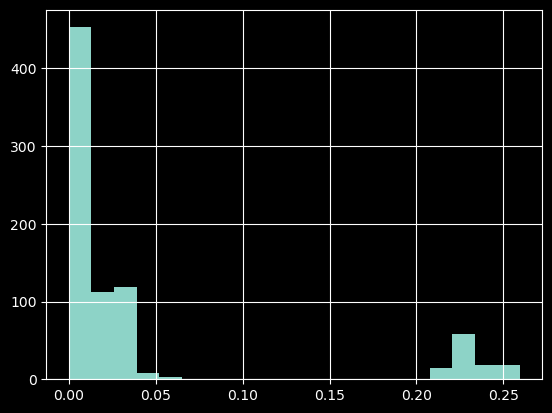

In [12]:
cols_feat = df.columns.drop(['key_daily', 'date', 'targ']).tolist()

df_frac_nullity = df[cols_feat].isnull().mean()
df_frac_nullity.hist(bins=20)

OK none of these are that bad. I'll keep them all.

<Axes: xlabel='date'>

date
1998       55
1999      864
2000     1043
2001    13417
2002    37604
2003    48777
2004    50688
2005    51083
2006    50014
2007    49284
2008    48478
Name: count, dtype: int64

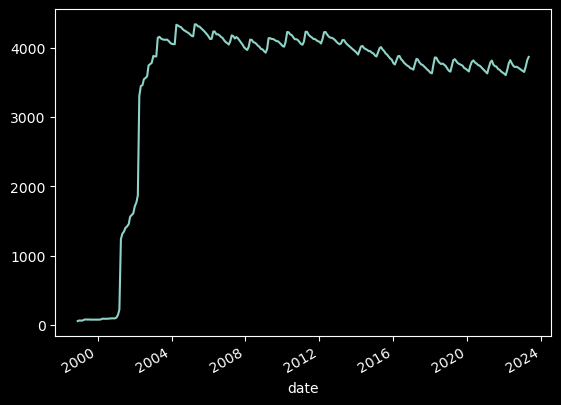

In [13]:
# Compute daily and yearly row counts
display(df.date.value_counts().sort_index().plot())
display(df.date.dt.year.value_counts().sort_index().head(11))

Let's extend TW1 through 2007, which will give it 5 years with full market data. Below I create train/predict folds in a way that gives prediction coverage from 2009 trough last year without the need to train one model for each year.

In [14]:
# Store training window partition
first_window_final_year = 2007
years_btw_windows = 4

last_year = df.date.max().year
train_window_limits = list(np.arange(first_window_final_year, last_year - 3, years_btw_windows))
pred_window_lists = [list(range(x + 2, x + years_btw_windows + 2)) for x in train_window_limits]

for ty, py in zip(train_window_limits, pred_window_lists):
    print('[..., {}]'.format(ty), '-->', py)

[..., 2007] --> [2009, 2010, 2011, 2012]
[..., 2011] --> [2013, 2014, 2015, 2016]
[..., 2015] --> [2017, 2018, 2019, 2020]
[..., 2019] --> [2021, 2022, 2023, 2024]


In [15]:
%%time
# For variable pairs with this absolute correlation or greater, keep only one.
max_corr = 0.95

# Sample within the first train window then compute correlation matrix.
tw1_limit = min(train_window_limits)
X_corr = df.loc[df.date.dt.year <= tw1_limit, cols_feat].sample(n=10000).corr()

# Convert to upper triangle then find list of columns with strong correlation.
X_corr = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
correlated_feat_drop = [c for c in X_corr.columns if any(X_corr[c].abs() > max_corr)]
print("Will drop {} of {} features.".format(str(len(correlated_feat_drop)), str(len(cols_feat))))

cols_feat_keep_low_corr = list(set(X_corr.columns).difference(set(correlated_feat_drop)))

Will drop 397 of 804 features.
CPU times: user 15.9 s, sys: 372 ms, total: 16.2 s
Wall time: 16.2 s


# Tune ML

For hyperparameter tuning, rather than using just a grid *or* an optimizer, I like to force a basic grid search *then* run an optimizer. Otherwise they seem prone to getting stuck at local optima. Optuna's `enqueue_trial()` allows for just this.

In [16]:
cudf_cash_crunch = cudf.from_pandas(df.loc[~df.targ.isnull(), ['key_daily', 'date', 'targ'] + cols_feat_keep_low_corr])
cudf_cash_crunch.shape

(792508, 410)

In [17]:
# Create boolean masks, which I call selectors, for train and prediction windows.
train_window_selectors = [cudf_cash_crunch.date.dt.year <= cutoff_yr for cutoff_yr in train_window_limits]
prediction_window_selectors = [cudf_cash_crunch.date.dt.year.isin(pwl) for pwl in pred_window_lists]
window_selectors = list(zip(train_window_selectors, prediction_window_selectors))

In [18]:
param_labels = ['n_estimators', 'learning_rate', 'max_depth', 'colsample_bytree', 'subsample', 'min_child_weight']

grid_n_estimators = [25, 250]
grid_learning_rate = [0.001, 0.01]
grid_max_depth = [3, 10]
grid_colsample_bytree = [0.1, 0.5]
grid_subsample = grid_colsample_bytree
grid_min_child_weight = [50, 500, 5000]

grid = product(grid_n_estimators, grid_learning_rate, grid_max_depth, grid_colsample_bytree, grid_subsample, grid_min_child_weight)
grid = [{param_labels[i]: g[i] for i in range(len(param_labels))} for g in grid]
print(len(grid), 'models in grid.')
pd.DataFrame(grid).head()

96 models in grid.


,n_estimators,learning_rate,max_depth,colsample_bytree,subsample,min_child_weight
0,25,0.001,3,0.100,0.100,50
1,25,0.001,3,0.100,0.100,500
2,25,0.001,3,0.100,0.100,5000
3,25,0.001,3,0.100,0.500,50
4,25,0.001,3,0.100,0.500,500


In [19]:
study = optuna.create_study(direction='maximize')

[I 2024-06-26 12:34:01,319] A new study created in memory with name: no-name-dfb9858c-96bf-4ef0-9f71-6c73948ed90c


In [20]:
for _t in grid:
    study.enqueue_trial(_t)

In [21]:
def run_trial(trial):
    global cudf_cash_crunch
    cudf_cash_crunch['pred'] = cupy.nan
    
    model_params = {
        'device': 'cuda',  # For xgboost>=2.0.0
        'tree_method': 'hist',  # For xgboost>=2.0.0
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 25, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 10),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01,1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100000)  # leaf sample cnt
    }
   
    for sel_train, sel_pred in window_selectors:
        clf = xgboost.XGBClassifier(**model_params)
        clf.fit(X=cudf_cash_crunch.loc[sel_train, cols_feat_keep_low_corr], y=cudf_cash_crunch.loc[sel_train, 'targ'])
        cudf_cash_crunch.loc[sel_pred, 'pred'] = clf.predict_proba(X=cudf_cash_crunch.loc[sel_pred, cols_feat_keep_low_corr])[:, 1]

    df_score = cudf_cash_crunch.loc[~cudf_cash_crunch.pred.isnull(), ['targ', 'pred']].to_pandas()
    return roc_auc_score(df_score.targ, df_score.pred)

In [ ]:
study.optimize(run_trial, 200)

In [24]:
df_hyperp = study.trials_dataframe().rename(columns={'value': 'roc_auc'})
cols_hyperp = ['roc_auc'] + df_hyperp.columns[df_hyperp.columns.str.contains('params_')].tolist()
df_hyperp[cols_hyperp].sort_values('roc_auc', ascending=False).head(20).style.background_gradient(cmap='coolwarm').format(precision=5)

,roc_auc,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_subsample
93,0.80828,0.50000,0.01000,10,50,250,0.50000
90,0.80421,0.50000,0.01000,10,50,250,0.10000
87,0.80383,0.10000,0.01000,10,50,250,0.50000
197,0.80237,0.88820,0.19489,14,7242,456,0.99143
195,0.80225,0.83032,0.19648,14,8112,454,0.99080
176,0.80195,0.91284,0.23378,15,5870,461,0.90256
194,0.80174,0.82435,0.21031,15,4884,479,0.82434
167,0.80157,0.93168,0.22984,15,6020,446,0.78511
189,0.80139,0.86875,0.22160,14,5437,481,0.93680
187,0.80101,0.92904,0.22382,15,4799,485,0.94217


# Assess best model

I'll take the best hyperparams and just glance at performance, since my main question has been answered: yes, the prediction problem has legs.

In [25]:
best_params = {'device': 'cuda',
               'tree_method': 'hist',
               'objective': 'binary:logistic',
               'colsample_bytree': 0.5,
               'learning_rate': 0.01,
               'max_depth': 10,
               'min_child_weight': 50,
               'n_estimators': 250,
               'subsample': 0.5
               }

In [26]:
cudf_cash_crunch['pred'] = cupy.nan

for cutoff_year in list(range(first_window_final_year, last_year - 1)):
    sel_train = cudf_cash_crunch.date.dt.year <= cutoff_year # oops
    sel_pred = cudf_cash_crunch.date.dt.year == cutoff_year + 1
    if (sel_train.sum() > 0) and (sel_pred.sum() > 0):
        clf = xgboost.XGBClassifier(**best_params)
        clf.fit(X=cudf_cash_crunch.loc[sel_train, cols_feat_keep_low_corr], y=cudf_cash_crunch.loc[sel_train, 'targ'])
        cudf_cash_crunch.loc[sel_pred, 'pred'] = clf.predict_proba(X=cudf_cash_crunch.loc[sel_pred, cols_feat_keep_low_corr])[:, 1]

In [27]:
_sel = (~cudf_cash_crunch.pred.isnull()) & (~cudf_cash_crunch.targ.isnull())
df_score = cudf_cash_crunch.loc[_sel, ['key_daily', 'date', 'targ', 'pred']].to_pandas()
df_score = df_score.merge(df_targ[['key_daily', 'ratio_adj_chg']], how='inner', on='key_daily')
df_score['pred2'] = df_score.pred.apply(lambda x: 1 if x > 0.5 else 0)
print(df_score.shape)
df_score.head()

(545352, 6)


,key_daily,date,targ,pred,ratio_adj_chg,pred2
0,SCI_2018-05-03,2018-05-03,0.000,0.090,0.000,0
1,ENSV_2009-11-04,2009-11-04,0.000,0.279,-10.391,0
2,SFL_2012-09-06,2012-09-06,0.000,0.184,1.218,0
3,SFL_2011-02-03,2011-02-03,0.000,0.228,0.000,0
4,AGU_2016-01-06,2016-01-06,0.000,0.189,0.000,0


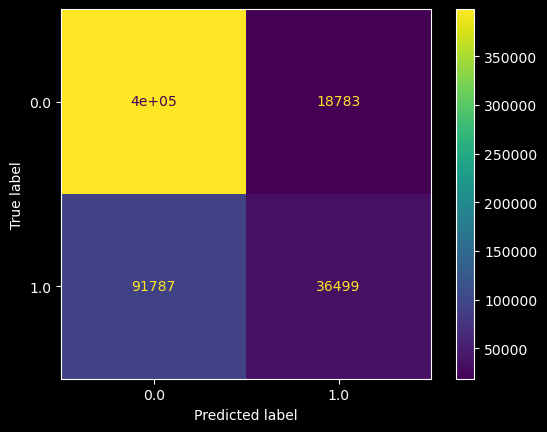

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
ConfusionMatrixDisplay.from_predictions(df_score.targ, df_score.pred2)

In [44]:
confusion_matrix(df_score.targ, df_score.pred2)/len(df_score)

array([[0.7303228 , 0.03444198],
       [0.16830781, 0.06692742]])

In [45]:
precision_score(df_score.targ, df_score.pred2), recall_score(df_score.targ, df_score.pred2)

(0.6602329872291162, 0.2845127293703132)

That recall is pretty dismal, though admittedly that's for a 0.5 threshold. ROC AUC should tell a more complete tale.

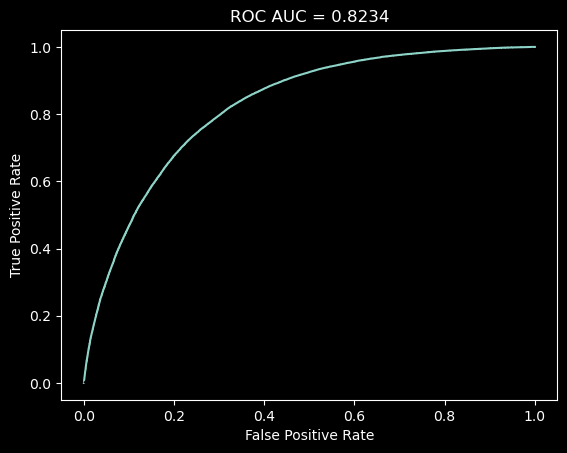

In [46]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc

fpr, tpr, thresholds = roc_curve(df_score.targ, df_score.pred)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC = {:.4f}'.format(auc_score))
plt.show()

Score through time? Meaning, as each subsequent models trained, did it improve with more historical stock data?

In [47]:
df_score.date.agg(['min', 'max'])

min   2008-01-04
max   2022-12-05
Name: date, dtype: datetime64[ns]

<Axes: >

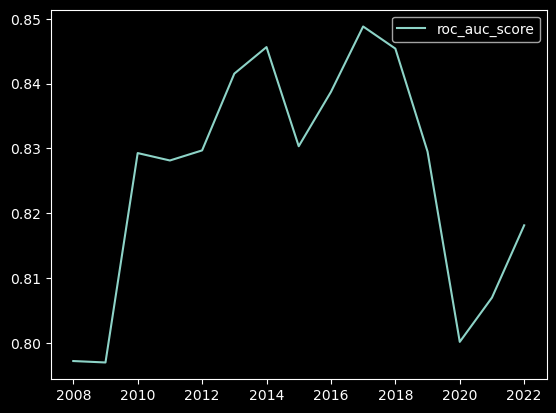

In [48]:
list_prediction_years = list(range(df_score.date.min().year, df_score.date.max().year + 1))
list_scores_yearly = []
for y in list_prediction_years:
    sel_pred_yr = df_score.date.dt.year == y
    fpr, tpr, thresholds = roc_curve(df_score.loc[sel_pred_yr, 'targ'], df_score.loc[sel_pred_yr, 'pred'])
    list_scores_yearly.append(auc(fpr, tpr))

pd.DataFrame({'roc_auc_score': list_scores_yearly}, index=list_prediction_years).plot()

There may indeed be a jagged upward trend in performance for subsequent models, with a massive 4% drop in AUC for the pandemic era. I suppose that speaks to model risk a bit.

Let's also peek at the predicted probabilities against the underlying continuous target with the help of LOWESS (scatterplot smoother).

<Axes: xlabel='pred', ylabel='ratio_adj_chg'>

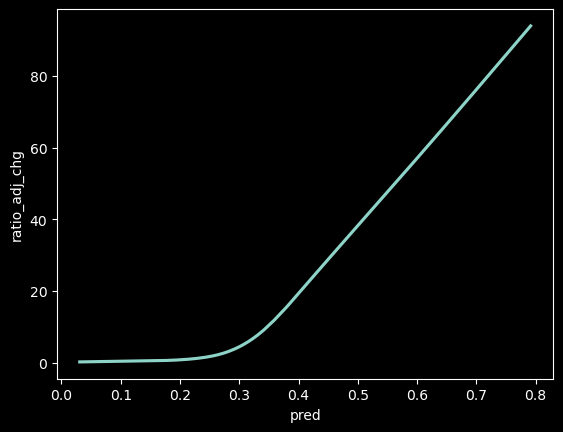

In [49]:
sns.regplot(data=df_score.sample(frac=0.1), x='pred', y='ratio_adj_chg', scatter=False, lowess=True)

I also wonder what features are prominent here for the final-year model, which was trained on most of the instances.

(407, 3)
21 features contribute 49.2% of cumulative importance


,feat,imp,imp_c
0,netinccmnusd_over_revenue_art,0.094,0.094
1,ncfo_over_assetsavg_art,0.080,0.173
2,netinccmnusd_over_revenue_ary5y_avg,0.045,0.218
3,liabilitiesc_over_fcf_ary5y_std,0.029,0.247
4,revenueusd_over_fcf_ary5y_std,0.025,0.272
5,ebitda_over_fcf_art,0.022,0.294
6,taxexp_over_revenue_art,0.019,0.313
7,assetsnc_over_assetsavg_ary5y_avg,0.018,0.331
8,capex_over_revenue_ary5y_avg,0.016,0.347
9,assetsnc_over_assetsavg_art,0.015,0.362


<Axes: >

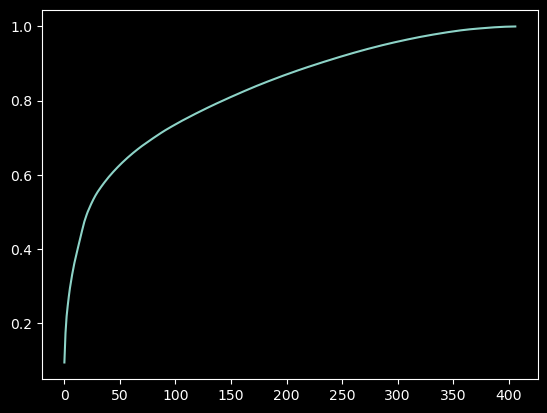

In [88]:
clf.importance_type = 'total_gain'
cumul_importance_thresh = 0.5

df_fi = pd.DataFrame({'feat': cols_feat_keep_low_corr, 'imp': clf.feature_importances_})
df_fi = df_fi.sort_values('imp', ascending=False).reset_index(drop=True)
df_fi['imp_c'] = df_fi.imp.cumsum()
important_features = df_fi.loc[df_fi.imp_c <= cumul_importance_thresh, 'feat']
threshold_contrib = df_fi.loc[df_fi.feat.isin(important_features), 'imp_c'].max()

print(df_fi.shape)
print(len(important_features), 'features contribute {}% of cumulative importance'.format((100.*threshold_contrib).round(1)))
df_fi.to_csv(data_path.joinpath("analytics_demo").joinpath('df_fi.csv'), index=None)
display(df_fi.head(20))
df_fi.loc[:, 'imp_c'].plot.line()

# Notes and To-Do's

- The above is what I hoped for: A couple dozen features pulling most of the weight.
    - I'm surprised to see profit margin (`netinccmnusd_over_revenue_art`) doing 9.4% of the predictive work for a cash flow target.
        - Combined with its 5-year average, it does nearly 14% of the work!
    - Unsurprisingly, the other half dozen top features involve cash flow somehow.
- I failed to create a lagged target as a feature; it just slipped my mind.
    - Then again, I expect that some of the top features (like `liabilitiesc_over_fcf_ary5y_std`) carry related information.
    - Still, I suspect I could add, say, 0.05 to the AUC score with a lagged target feature.
- I was in a hurry and chose `binary:logistic` as XGB's objective function rather than `reg:logistic`, but really it would've been wiser to either think carefully about this, or tune it as a hyperparam.
    - Note: A quick search indicates that `binary:logistic` scores a split on accuracy, while `reg:logistic` uses RMSE somehow.
- Given the importance of catching risky borrowers, we likely need to understand recall behavior better.
- Once we were happy with our feature set and model performance, we'd want to lower dimensionality via feature combination into latent dimensions, rather than simply removing correlated features or relying on supervised models (feature importance, SHAP files). Potential techniques include:
    - PCA
    - Autoencoder
    - Feature network
- With luck, studying latent dimensions will enable the design of robust features from a small handful of financial details, perfect for a business credit application.